In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings


In [2]:
#hyper params
lr = 1e-3
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 60
hardness_threshold = 0.60
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4
classes = [0,1,17,2,3,4] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './Irrelevant_Balanced'


In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [8]:
def train_model(trainset,valset, model, criterion, optimizer, scheduler_train , scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }

    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in dataloaders_strong[phase]:
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # AdaMatch steps
                    if phase == 'train':
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())


                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                                                
                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs = inputs[skip_mask]
                            labels = labels[skip_mask]
                            preds = preds[skip_mask]
                            loss = criterion(outputs[skip_mask], preds)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.item())
                E_loss_train.append(epoch_loss)
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
                E_accuracy_train.append(epoch_acc)
            else:
                entropy_values_val.append(epoch_entropy.item())
                E_loss_val.append(epoch_loss)
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation
                E_accuracy_val.append(epoch_acc)


            
            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            
            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [9]:
def test_model(model, testset, hardness_threshold):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

         # Calculate hardness score for each sample in the batch
            probabilities_hard = torch.softmax(outputs, dim=1)
            hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

            # Skip predictions if hardness score is greater than the threshold
            skip_mask = hardness_scores <= hardness_threshold
                    
                    
            if skip_mask.sum().item() > 0:
                c += 1
                inputs = inputs[skip_mask]
                labels = labels[skip_mask]
                preds = preds[skip_mask]
                
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / (len(testset)-c)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)
    print("Skipped Inputs:", c)
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [10]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [11]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [12]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        
    elif model_name == "mobilenet":
        # Mobilenet_V2
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = models.vit_b_16(weights = models.ViT_B_16_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, requires_grad=use_pretrained)
        #num_features = model_ft.fc.in_features
        #model_ft.fc = nn.Sequential(
                   # nn.Linear(num_features, 512),
                    #nn.ReLU(),
                    #nn.Linear(512, num_classes)
                    #)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [13]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [14]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [15]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(path, val_size, test_size)

train : 9942 val : 2486 test : 2194


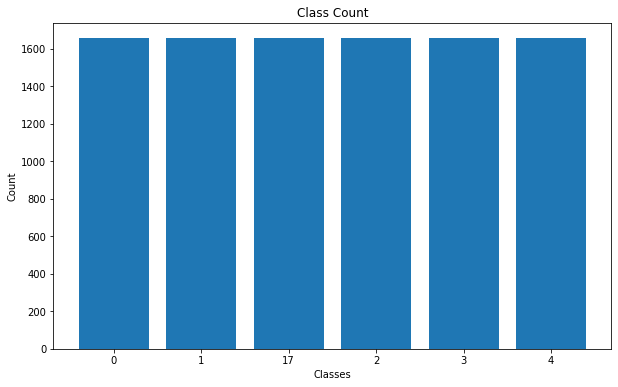

In [15]:
plot_distribution_by_class(trainset, classes)

/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40.

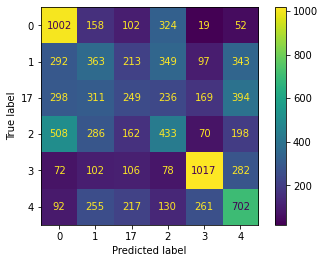

<Figure size 576x432 with 0 Axes>

Number of skipped: 308

val Loss: 0.3660 Acc: 0.3347
val Epoch Entropy: 2.2930
val Balanced Accuracy: 0.6667



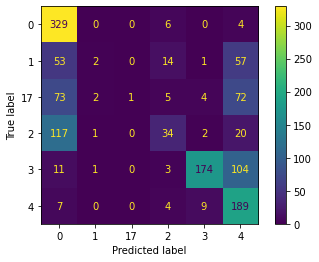

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 1.3846 Acc: 0.4329
train Epoch Entropy: 1.9172
train Balanced Accuracy: 0.5000



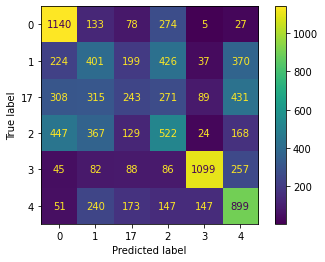

<Figure size 576x432 with 0 Axes>

Number of skipped: 309

val Loss: 0.2309 Acc: 0.3091
val Epoch Entropy: 2.2452
val Balanced Accuracy: 0.5000



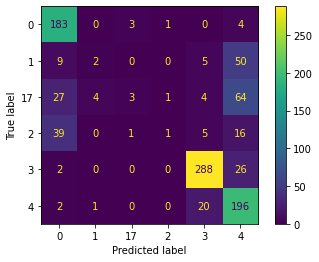

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 1.4305 Acc: 0.4285
train Epoch Entropy: 1.9126
train Balanced Accuracy: 0.5000



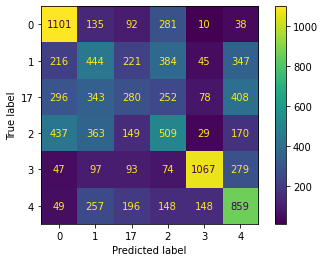

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.2510 Acc: 0.2860
val Epoch Entropy: 2.2592
val Balanced Accuracy: 1.0000



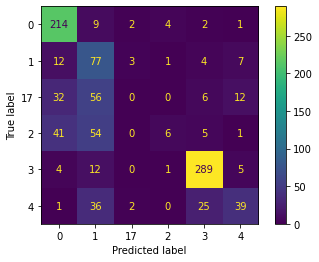

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 1.3495 Acc: 0.4636
train Epoch Entropy: 1.8762
train Balanced Accuracy: 0.7222



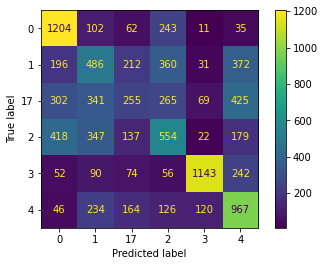

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2562 Acc: 0.3658
val Epoch Entropy: 2.0700
val Balanced Accuracy: 0.0000



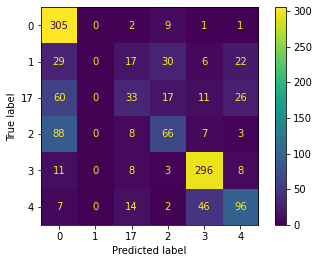

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 1.3326 Acc: 0.4772
train Epoch Entropy: 1.8431
train Balanced Accuracy: 0.6250



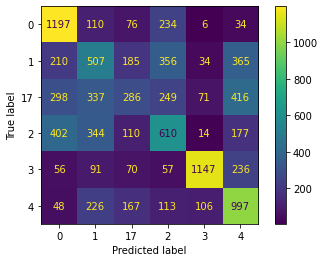

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.3368 Acc: 0.4154
val Epoch Entropy: 2.1513
val Balanced Accuracy: 0.5000



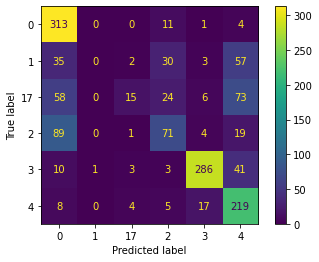

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 1.3226 Acc: 0.4729
train Epoch Entropy: 1.8271
train Balanced Accuracy: 0.5833



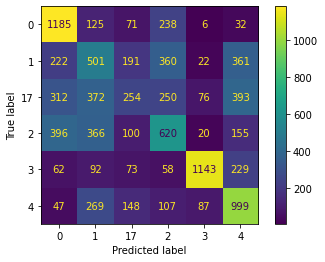

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2455 Acc: 0.3651
val Epoch Entropy: 2.1539
val Balanced Accuracy: 1.0000



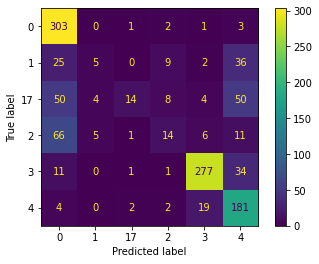

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 1.3003 Acc: 0.4899
train Epoch Entropy: 1.8126
train Balanced Accuracy: 0.3333



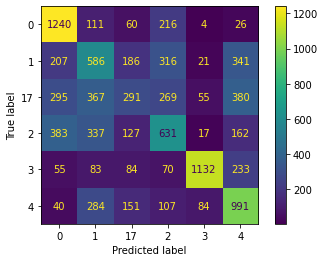

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2785 Acc: 0.3793
val Epoch Entropy: 2.1697
val Balanced Accuracy: 0.2500



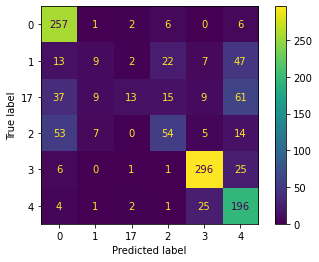

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 1.3003 Acc: 0.4918
train Epoch Entropy: 1.8055
train Balanced Accuracy: 0.2500



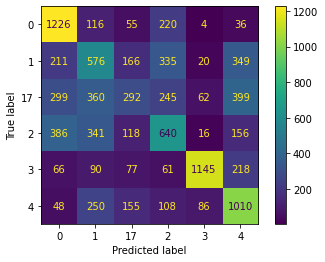

<Figure size 576x432 with 0 Axes>

Number of skipped: 309

val Loss: 0.2875 Acc: 0.3927
val Epoch Entropy: 2.1240
val Balanced Accuracy: 0.5000



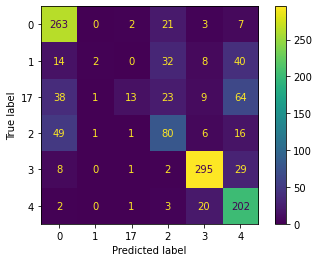

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 1.2431 Acc: 0.5136
train Epoch Entropy: 1.7902
train Balanced Accuracy: 0.6667



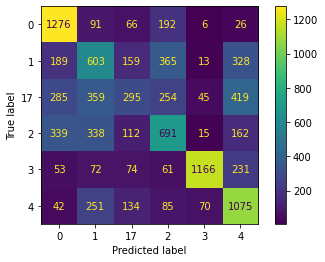

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2904 Acc: 0.4246
val Epoch Entropy: 2.0441
val Balanced Accuracy: 0.7500



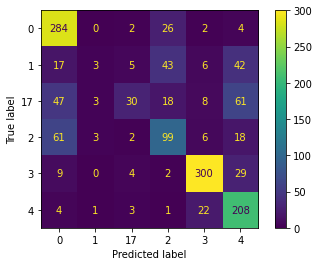

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------

train Loss: 1.2239 Acc: 0.5185
train Epoch Entropy: 1.7526
train Balanced Accuracy: 0.5000



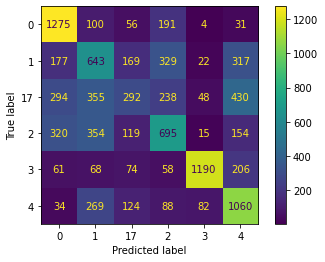

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2767 Acc: 0.4244
val Epoch Entropy: 2.0552
val Balanced Accuracy: 0.5000



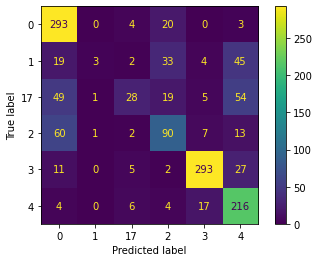

<Figure size 576x432 with 0 Axes>

Epoch 10/59
----------

train Loss: 1.2206 Acc: 0.5185
train Epoch Entropy: 1.7538
train Balanced Accuracy: 0.5556



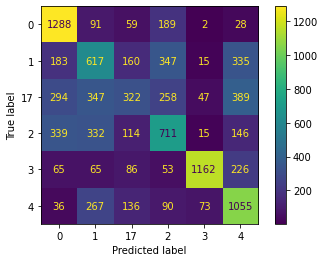

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2900 Acc: 0.4274
val Epoch Entropy: 2.0609
val Balanced Accuracy: 0.3333



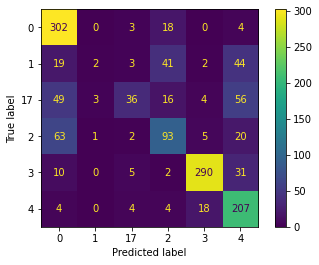

<Figure size 576x432 with 0 Axes>

Epoch 11/59
----------

train Loss: 1.2204 Acc: 0.5207
train Epoch Entropy: 1.7554
train Balanced Accuracy: 0.3750



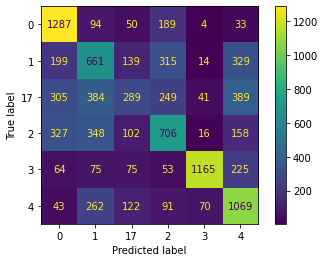

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2855 Acc: 0.4248
val Epoch Entropy: 2.0609
val Balanced Accuracy: 0.6667



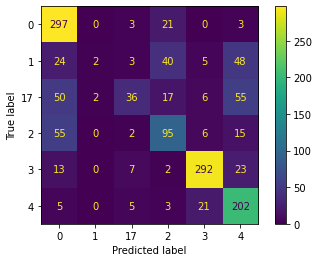

<Figure size 576x432 with 0 Axes>

Epoch 12/59
----------

train Loss: 1.2183 Acc: 0.5275
train Epoch Entropy: 1.7594
train Balanced Accuracy: 0.7500



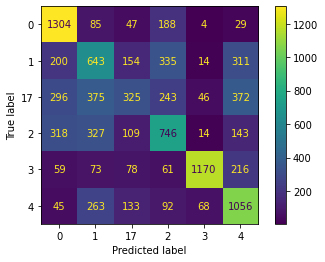

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2799 Acc: 0.4290
val Epoch Entropy: 2.0506
val Balanced Accuracy: 1.0000



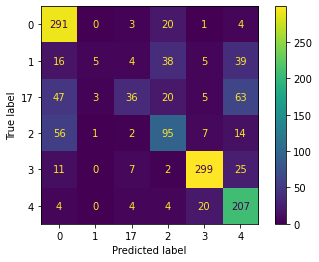

<Figure size 576x432 with 0 Axes>

Epoch 13/59
----------

train Loss: 1.2177 Acc: 0.5245
train Epoch Entropy: 1.7579
train Balanced Accuracy: 0.8750



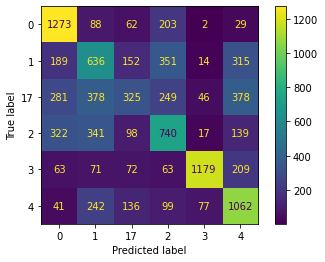

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2996 Acc: 0.4301
val Epoch Entropy: 2.0471
val Balanced Accuracy: 0.6250



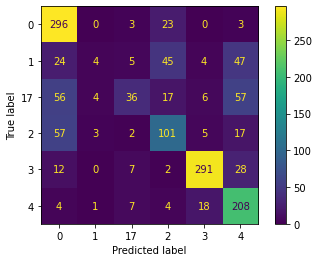

<Figure size 576x432 with 0 Axes>

Epoch 14/59
----------

train Loss: 1.2190 Acc: 0.5207
train Epoch Entropy: 1.7532
train Balanced Accuracy: 0.5000



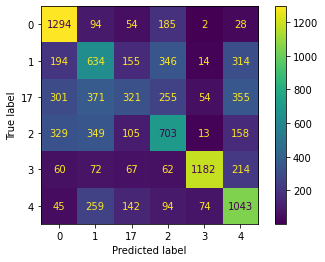

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2766 Acc: 0.4230
val Epoch Entropy: 2.0561
val Balanced Accuracy: 1.0000



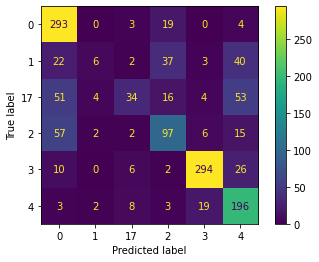

<Figure size 576x432 with 0 Axes>

Epoch 15/59
----------

train Loss: 1.2207 Acc: 0.5217
train Epoch Entropy: 1.7534
train Balanced Accuracy: 0.8333



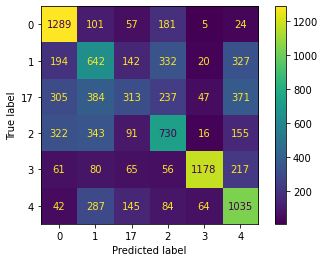

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2920 Acc: 0.4265
val Epoch Entropy: 2.0538
val Balanced Accuracy: 0.5000



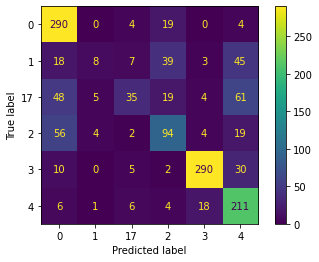

<Figure size 576x432 with 0 Axes>

Epoch 16/59
----------

train Loss: 1.2184 Acc: 0.5245
train Epoch Entropy: 1.7545
train Balanced Accuracy: 0.8000



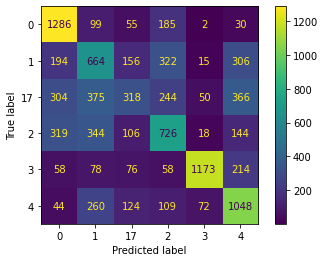

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2891 Acc: 0.4301
val Epoch Entropy: 2.0481
val Balanced Accuracy: 0.0000



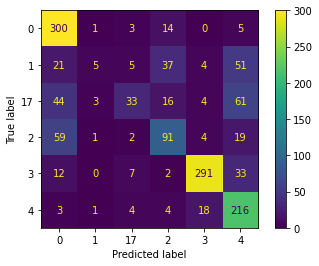

<Figure size 576x432 with 0 Axes>

Epoch 17/59
----------

train Loss: 1.2181 Acc: 0.5201
train Epoch Entropy: 1.7528
train Balanced Accuracy: 0.8000



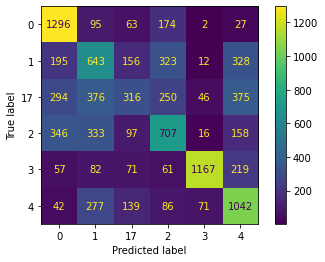

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2800 Acc: 0.4248
val Epoch Entropy: 2.0463
val Balanced Accuracy: 0.5000



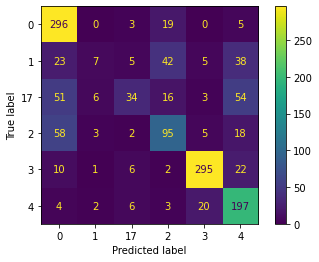

<Figure size 576x432 with 0 Axes>

Epoch 18/59
----------

train Loss: 1.2152 Acc: 0.5273
train Epoch Entropy: 1.7529
train Balanced Accuracy: 0.5556



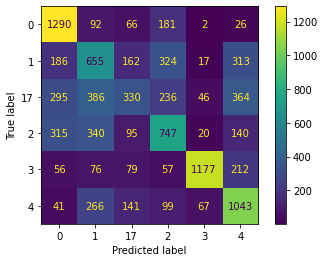

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2931 Acc: 0.4334
val Epoch Entropy: 2.0587
val Balanced Accuracy: 0.5000



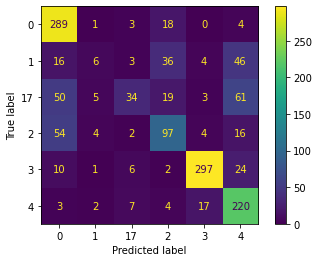

<Figure size 576x432 with 0 Axes>

Epoch 19/59
----------

train Loss: 1.2162 Acc: 0.5250
train Epoch Entropy: 1.7563
train Balanced Accuracy: 0.5000



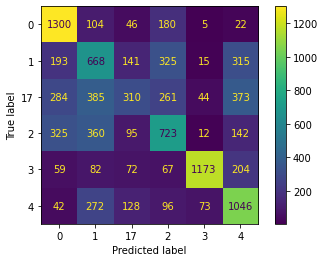

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2897 Acc: 0.4322
val Epoch Entropy: 2.0559
val Balanced Accuracy: 0.5000



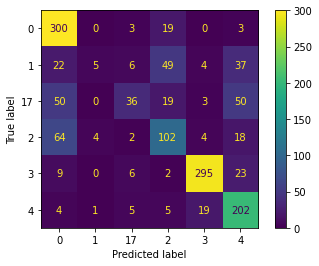

<Figure size 576x432 with 0 Axes>

Epoch 20/59
----------

train Loss: 1.2127 Acc: 0.5219
train Epoch Entropy: 1.7524
train Balanced Accuracy: 0.3750



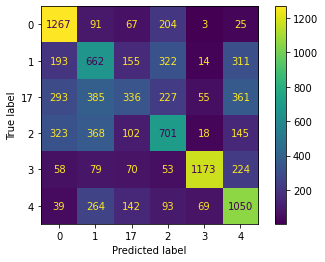

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2851 Acc: 0.4317
val Epoch Entropy: 2.0512
val Balanced Accuracy: 1.0000



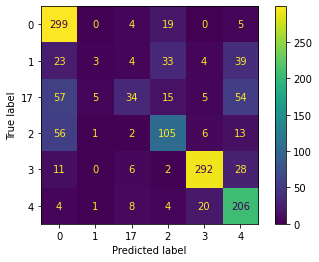

<Figure size 576x432 with 0 Axes>

Epoch 21/59
----------

train Loss: 1.2155 Acc: 0.5238
train Epoch Entropy: 1.7553
train Balanced Accuracy: 0.2500



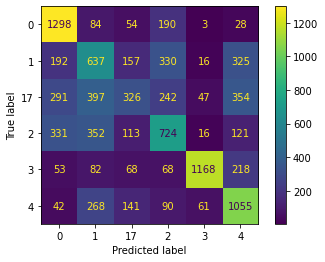

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2898 Acc: 0.4311
val Epoch Entropy: 2.0520
val Balanced Accuracy: 0.0000



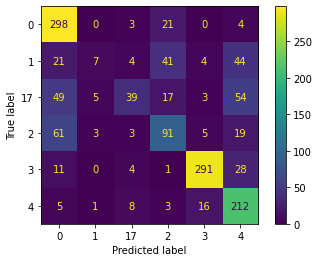

<Figure size 576x432 with 0 Axes>

Epoch 22/59
----------

train Loss: 1.2129 Acc: 0.5263
train Epoch Entropy: 1.7566
train Balanced Accuracy: 0.2500



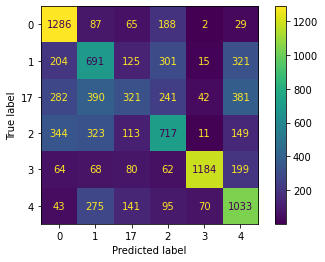

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2914 Acc: 0.4274
val Epoch Entropy: 2.0528
val Balanced Accuracy: 1.0000



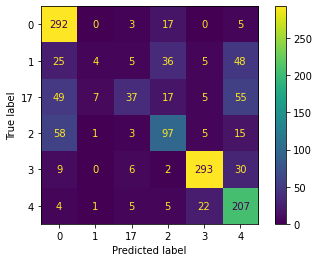

<Figure size 576x432 with 0 Axes>

Epoch 23/59
----------

train Loss: 1.2155 Acc: 0.5268
train Epoch Entropy: 1.7489
train Balanced Accuracy: 0.5000



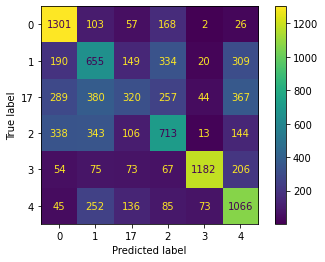

<Figure size 576x432 with 0 Axes>

Number of skipped: 308

val Loss: 0.3118 Acc: 0.4307
val Epoch Entropy: 2.0585
val Balanced Accuracy: 1.0000



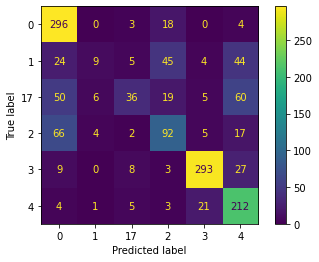

<Figure size 576x432 with 0 Axes>

Epoch 24/59
----------

train Loss: 1.2097 Acc: 0.5284
train Epoch Entropy: 1.7504
train Balanced Accuracy: 0.6667



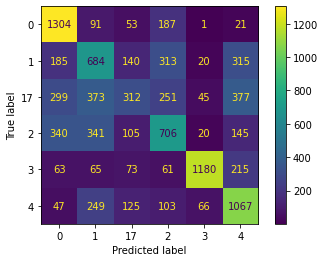

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2829 Acc: 0.4202
val Epoch Entropy: 2.0476
val Balanced Accuracy: 0.5000



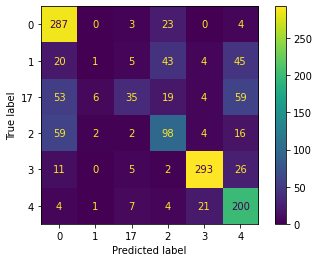

<Figure size 576x432 with 0 Axes>

Epoch 25/59
----------

train Loss: 1.2160 Acc: 0.5266
train Epoch Entropy: 1.7544
train Balanced Accuracy: 0.8889



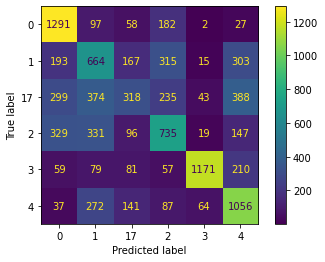

<Figure size 576x432 with 0 Axes>

Number of skipped: 309

val Loss: 0.3045 Acc: 0.4345
val Epoch Entropy: 2.0447
val Balanced Accuracy: 1.0000



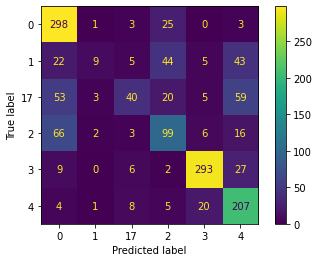

<Figure size 576x432 with 0 Axes>

Epoch 26/59
----------

train Loss: 1.2114 Acc: 0.5239
train Epoch Entropy: 1.7553
train Balanced Accuracy: 0.2500



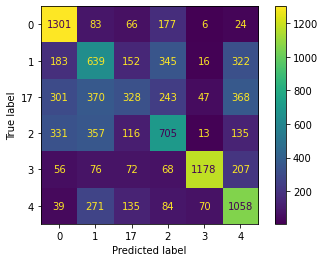

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.3045 Acc: 0.4343
val Epoch Entropy: 2.0538
val Balanced Accuracy: 0.5000



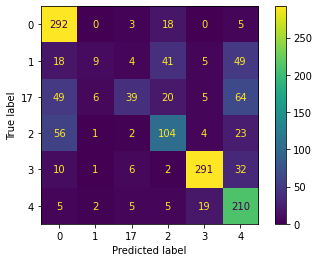

<Figure size 576x432 with 0 Axes>

Epoch 27/59
----------

train Loss: 1.2174 Acc: 0.5246
train Epoch Entropy: 1.7558
train Balanced Accuracy: 0.6250



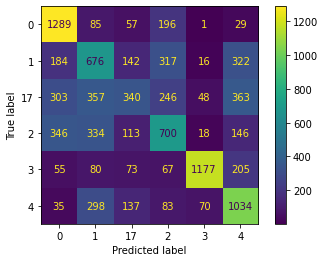

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2958 Acc: 0.4283
val Epoch Entropy: 2.0589
val Balanced Accuracy: 1.0000



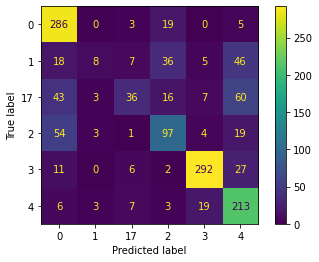

<Figure size 576x432 with 0 Axes>

Epoch 28/59
----------

train Loss: 1.2133 Acc: 0.5305
train Epoch Entropy: 1.7539
train Balanced Accuracy: 0.3333



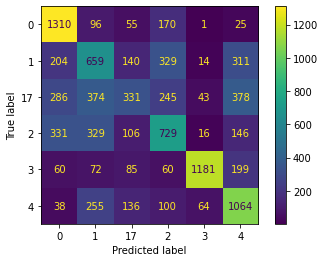

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2936 Acc: 0.4299
val Epoch Entropy: 2.0524
val Balanced Accuracy: 1.0000



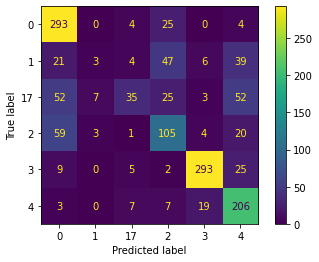

<Figure size 576x432 with 0 Axes>

Epoch 29/59
----------

train Loss: 1.2148 Acc: 0.5267
train Epoch Entropy: 1.7490
train Balanced Accuracy: 0.5000



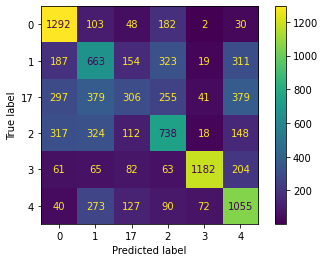

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2925 Acc: 0.4294
val Epoch Entropy: 2.0480
val Balanced Accuracy: 0.3750



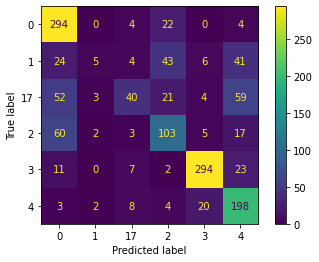

<Figure size 576x432 with 0 Axes>

Epoch 30/59
----------

train Loss: 1.2146 Acc: 0.5250
train Epoch Entropy: 1.7572
train Balanced Accuracy: 0.6000



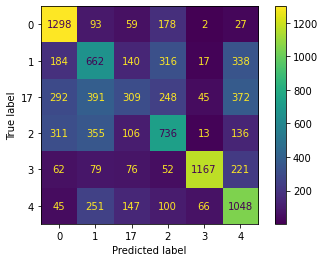

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2826 Acc: 0.4239
val Epoch Entropy: 2.0491
val Balanced Accuracy: 1.0000



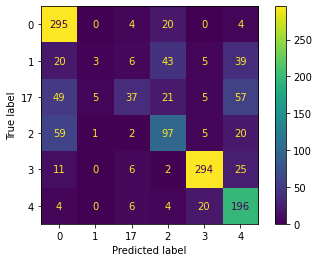

<Figure size 576x432 with 0 Axes>

Epoch 31/59
----------

train Loss: 1.2177 Acc: 0.5262
train Epoch Entropy: 1.7563
train Balanced Accuracy: 0.5833



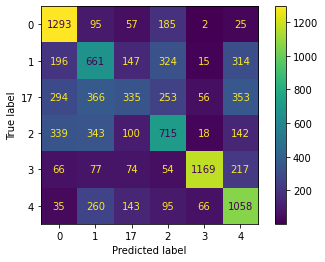

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2969 Acc: 0.4308
val Epoch Entropy: 2.0661
val Balanced Accuracy: 0.6667



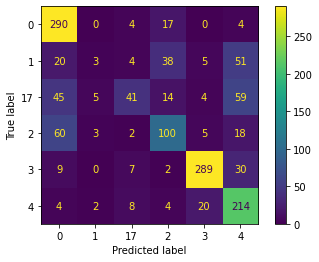

<Figure size 576x432 with 0 Axes>

Epoch 32/59
----------

train Loss: 1.2214 Acc: 0.5210
train Epoch Entropy: 1.7544
train Balanced Accuracy: 0.6667



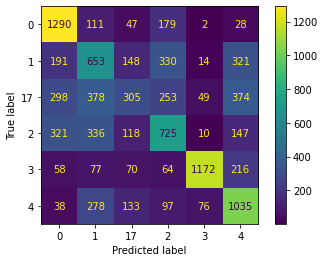

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2918 Acc: 0.4283
val Epoch Entropy: 2.0498
val Balanced Accuracy: 0.7500



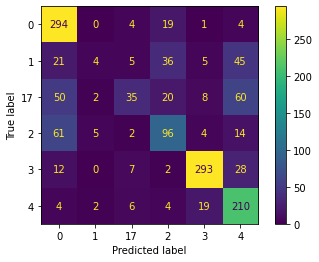

<Figure size 576x432 with 0 Axes>

Epoch 33/59
----------

train Loss: 1.2118 Acc: 0.5263
train Epoch Entropy: 1.7542
train Balanced Accuracy: 0.3333



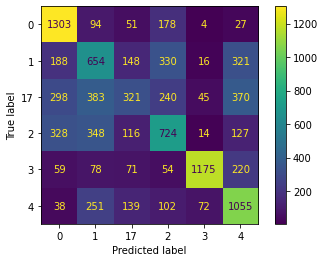

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2885 Acc: 0.4271
val Epoch Entropy: 2.0624
val Balanced Accuracy: 1.0000



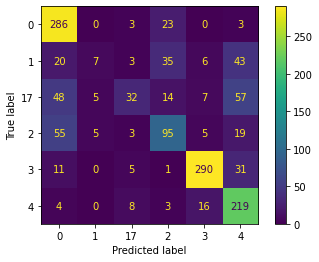

<Figure size 576x432 with 0 Axes>

Epoch 34/59
----------

train Loss: 1.2183 Acc: 0.5222
train Epoch Entropy: 1.7583
train Balanced Accuracy: 0.4167



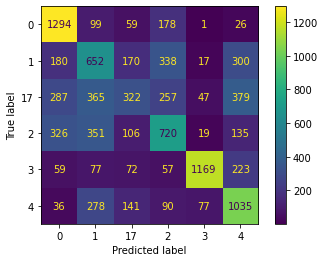

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2947 Acc: 0.4251
val Epoch Entropy: 2.0570
val Balanced Accuracy: 0.6667



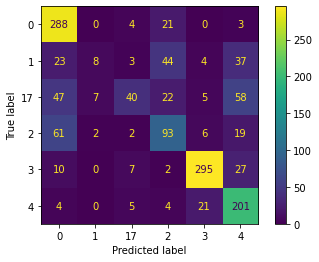

<Figure size 576x432 with 0 Axes>

Epoch 35/59
----------

train Loss: 1.2151 Acc: 0.5190
train Epoch Entropy: 1.7550
train Balanced Accuracy: 0.3333



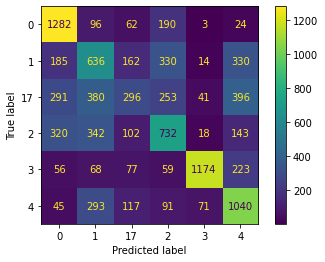

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2988 Acc: 0.4317
val Epoch Entropy: 2.0505
val Balanced Accuracy: 0.3750



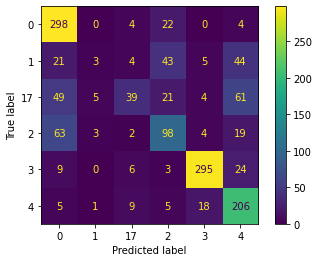

<Figure size 576x432 with 0 Axes>

Epoch 36/59
----------

train Loss: 1.2175 Acc: 0.5216
train Epoch Entropy: 1.7512
train Balanced Accuracy: 0.8333



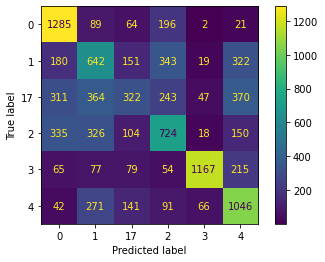

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.3002 Acc: 0.4311
val Epoch Entropy: 2.0614
val Balanced Accuracy: 0.5000



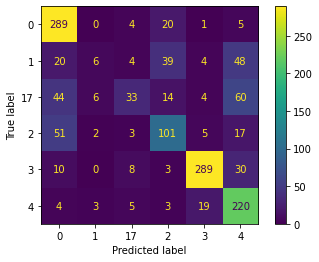

<Figure size 576x432 with 0 Axes>

Epoch 37/59
----------

train Loss: 1.2159 Acc: 0.5249
train Epoch Entropy: 1.7538
train Balanced Accuracy: 0.4000



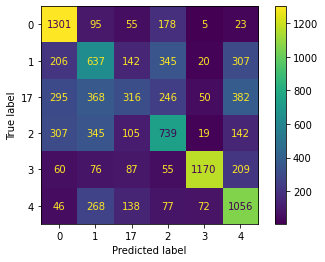

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2866 Acc: 0.4262
val Epoch Entropy: 2.0505
val Balanced Accuracy: 0.5000



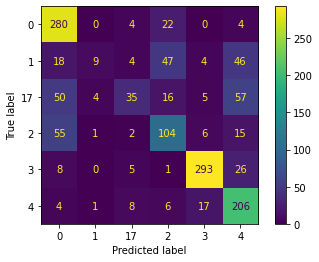

<Figure size 576x432 with 0 Axes>

Epoch 38/59
----------

train Loss: 1.2108 Acc: 0.5265
train Epoch Entropy: 1.7550
train Balanced Accuracy: 0.3333



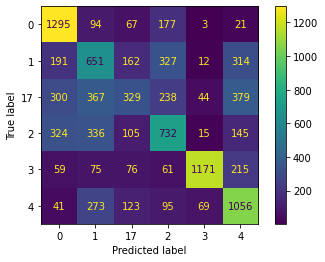

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2914 Acc: 0.4251
val Epoch Entropy: 2.0508
val Balanced Accuracy: 0.5000



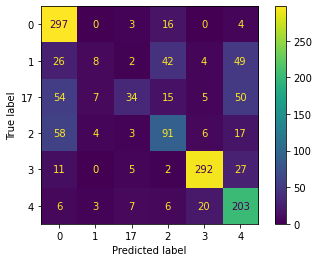

<Figure size 576x432 with 0 Axes>

Epoch 39/59
----------

train Loss: 1.2183 Acc: 0.5226
train Epoch Entropy: 1.7509
train Balanced Accuracy: 0.7500



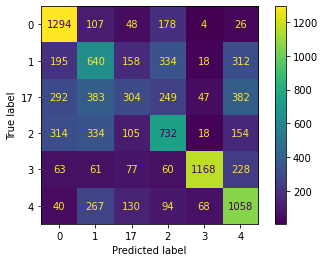

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.3056 Acc: 0.4347
val Epoch Entropy: 2.0449
val Balanced Accuracy: 1.0000



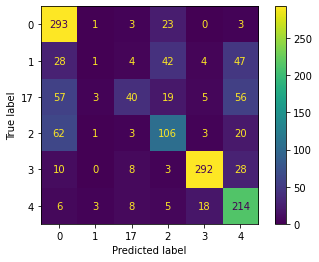

<Figure size 576x432 with 0 Axes>

Epoch 40/59
----------

train Loss: 1.2186 Acc: 0.5245
train Epoch Entropy: 1.7575
train Balanced Accuracy: 0.4000



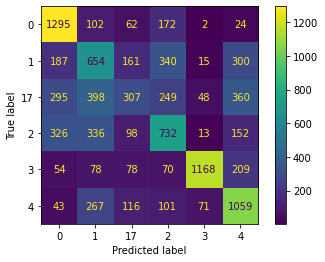

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2910 Acc: 0.4299
val Epoch Entropy: 2.0566
val Balanced Accuracy: 0.3333



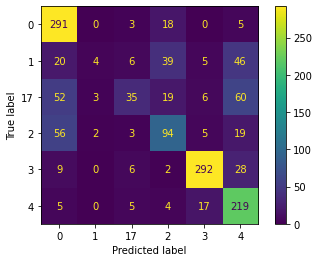

<Figure size 576x432 with 0 Axes>

Epoch 41/59
----------

train Loss: 1.2153 Acc: 0.5209
train Epoch Entropy: 1.7556
train Balanced Accuracy: 0.6250



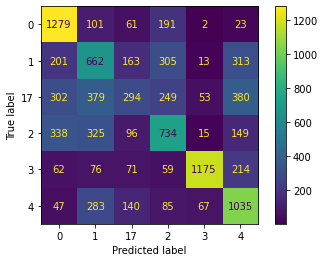

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2901 Acc: 0.4233
val Epoch Entropy: 2.0620
val Balanced Accuracy: 0.6667



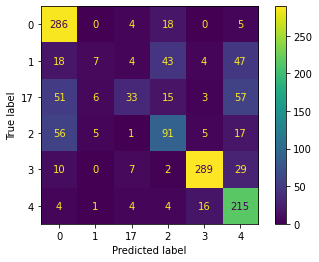

<Figure size 576x432 with 0 Axes>

Epoch 42/59
----------

train Loss: 1.2210 Acc: 0.5238
train Epoch Entropy: 1.7541
train Balanced Accuracy: 0.3000



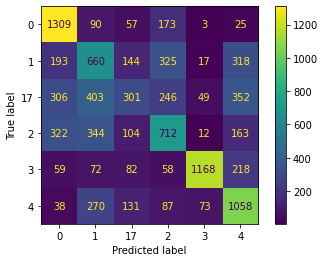

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2965 Acc: 0.4320
val Epoch Entropy: 2.0626
val Balanced Accuracy: 0.8000



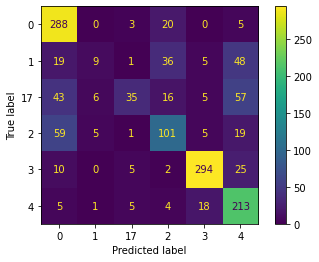

<Figure size 576x432 with 0 Axes>

Epoch 43/59
----------

train Loss: 1.2146 Acc: 0.5289
train Epoch Entropy: 1.7524
train Balanced Accuracy: 0.6667



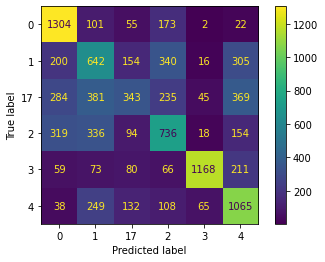

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2933 Acc: 0.4290
val Epoch Entropy: 2.0482
val Balanced Accuracy: 0.6667



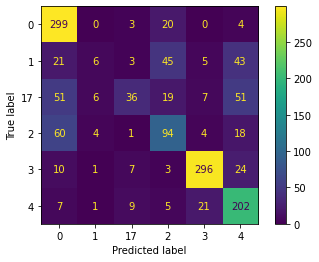

<Figure size 576x432 with 0 Axes>

Epoch 44/59
----------

train Loss: 1.2160 Acc: 0.5288
train Epoch Entropy: 1.7530
train Balanced Accuracy: 0.5000



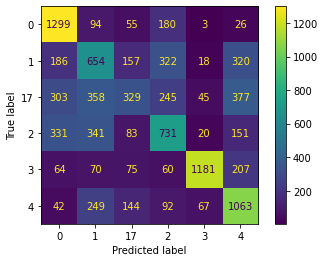

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2984 Acc: 0.4391
val Epoch Entropy: 2.0476
val Balanced Accuracy: 0.7500



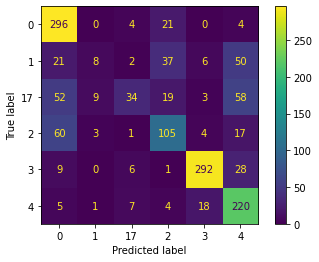

<Figure size 576x432 with 0 Axes>

Epoch 45/59
----------

train Loss: 1.2171 Acc: 0.5241
train Epoch Entropy: 1.7531
train Balanced Accuracy: 0.2500



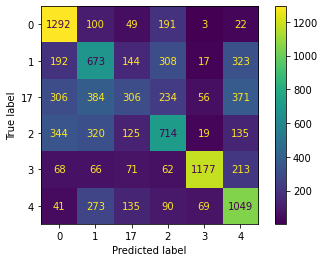

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2851 Acc: 0.4271
val Epoch Entropy: 2.0505
val Balanced Accuracy: 1.0000



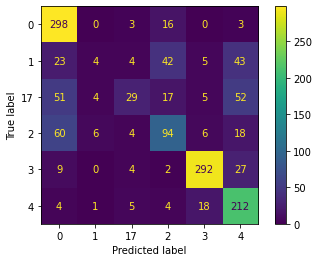

<Figure size 576x432 with 0 Axes>

Epoch 46/59
----------

train Loss: 1.2143 Acc: 0.5261
train Epoch Entropy: 1.7553
train Balanced Accuracy: 0.6250



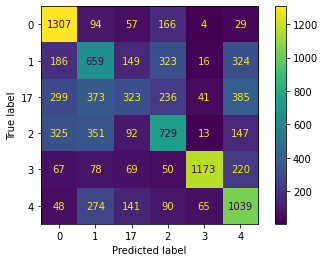

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2837 Acc: 0.4285
val Epoch Entropy: 2.0533
val Balanced Accuracy: 1.0000



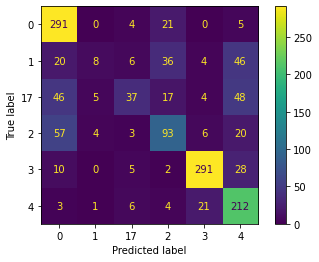

<Figure size 576x432 with 0 Axes>

Epoch 47/59
----------

train Loss: 1.2117 Acc: 0.5219
train Epoch Entropy: 1.7533
train Balanced Accuracy: 0.4444



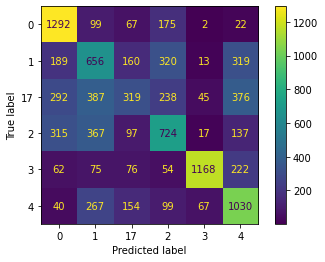

<Figure size 576x432 with 0 Axes>

Number of skipped: 309

val Loss: 0.3009 Acc: 0.4327
val Epoch Entropy: 2.0522
val Balanced Accuracy: 0.2000



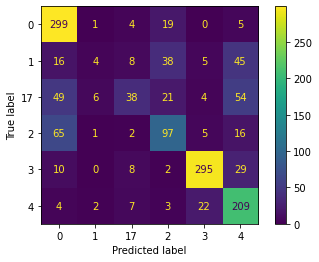

<Figure size 576x432 with 0 Axes>

Epoch 48/59
----------

train Loss: 1.2175 Acc: 0.5228
train Epoch Entropy: 1.7561
train Balanced Accuracy: 0.4000



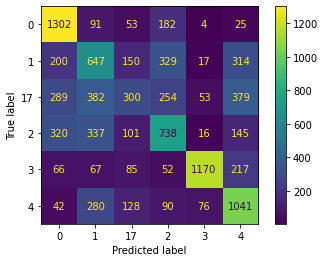

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2897 Acc: 0.4276
val Epoch Entropy: 2.0535
val Balanced Accuracy: 0.5000



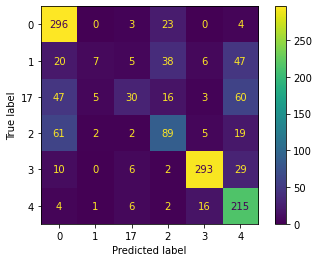

<Figure size 576x432 with 0 Axes>

Epoch 49/59
----------

train Loss: 1.2175 Acc: 0.5231
train Epoch Entropy: 1.7554
train Balanced Accuracy: 0.5000



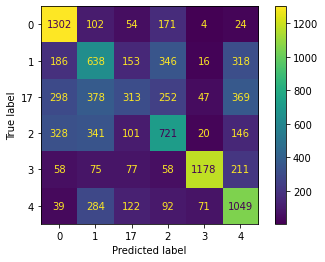

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.3011 Acc: 0.4306
val Epoch Entropy: 2.0452
val Balanced Accuracy: 0.0000



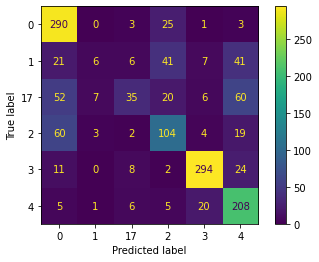

<Figure size 576x432 with 0 Axes>

Epoch 50/59
----------

train Loss: 1.2180 Acc: 0.5228
train Epoch Entropy: 1.7544
train Balanced Accuracy: 0.5000



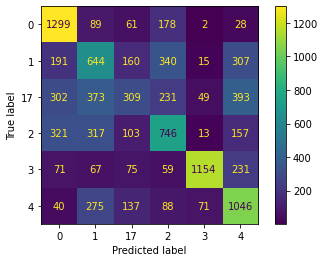

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2930 Acc: 0.4297
val Epoch Entropy: 2.0460
val Balanced Accuracy: 0.6667



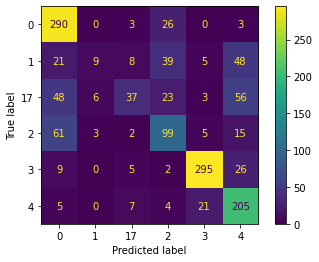

<Figure size 576x432 with 0 Axes>

Epoch 51/59
----------

train Loss: 1.2134 Acc: 0.5204
train Epoch Entropy: 1.7533
train Balanced Accuracy: 0.7500



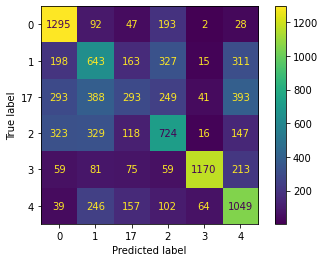

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2966 Acc: 0.4292
val Epoch Entropy: 2.0473
val Balanced Accuracy: 0.0000



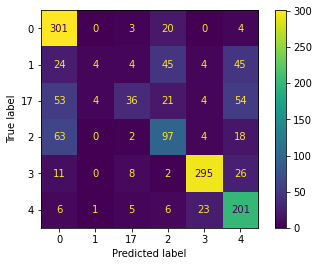

<Figure size 576x432 with 0 Axes>

Epoch 52/59
----------

train Loss: 1.2082 Acc: 0.5280
train Epoch Entropy: 1.7518
train Balanced Accuracy: 0.8750



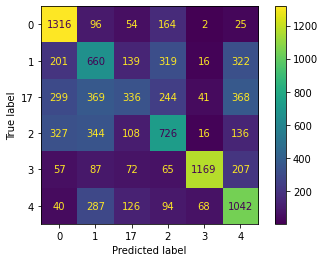

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2974 Acc: 0.4276
val Epoch Entropy: 2.0581
val Balanced Accuracy: 0.5000



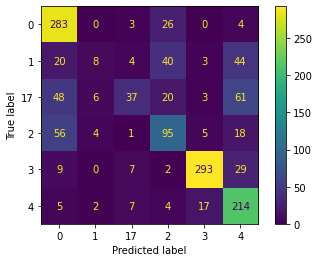

<Figure size 576x432 with 0 Axes>

Epoch 53/59
----------

train Loss: 1.2169 Acc: 0.5239
train Epoch Entropy: 1.7529
train Balanced Accuracy: 0.7222



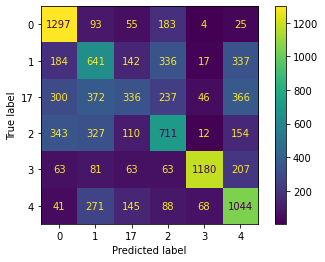

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2862 Acc: 0.4221
val Epoch Entropy: 2.0520
val Balanced Accuracy: 1.0000



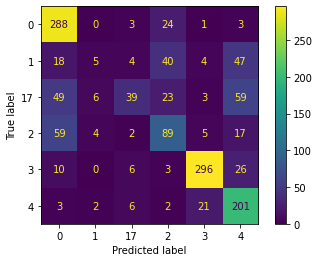

<Figure size 576x432 with 0 Axes>

Epoch 54/59
----------

train Loss: 1.2126 Acc: 0.5244
train Epoch Entropy: 1.7543
train Balanced Accuracy: 1.0000



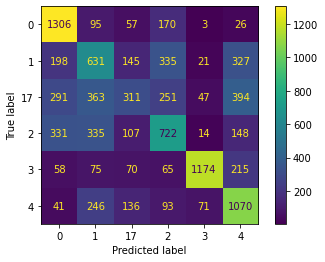

<Figure size 576x432 with 0 Axes>

Number of skipped: 309

val Loss: 0.2950 Acc: 0.4240
val Epoch Entropy: 2.0587
val Balanced Accuracy: 0.5000



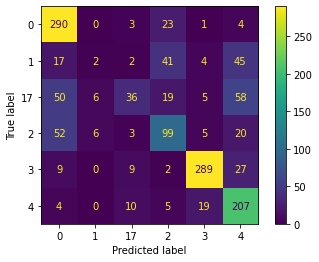

<Figure size 576x432 with 0 Axes>

Epoch 55/59
----------

train Loss: 1.2141 Acc: 0.5227
train Epoch Entropy: 1.7592
train Balanced Accuracy: 0.5000



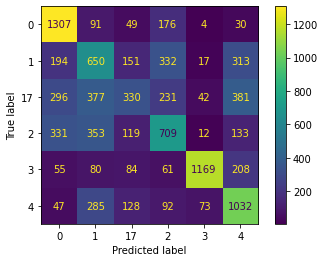

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2900 Acc: 0.4288
val Epoch Entropy: 2.0619
val Balanced Accuracy: 1.0000



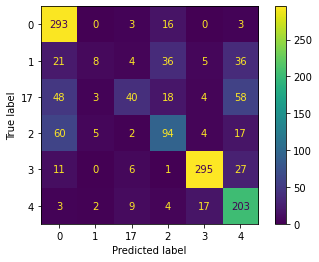

<Figure size 576x432 with 0 Axes>

Epoch 56/59
----------

train Loss: 1.2146 Acc: 0.5284
train Epoch Entropy: 1.7540
train Balanced Accuracy: 0.7500



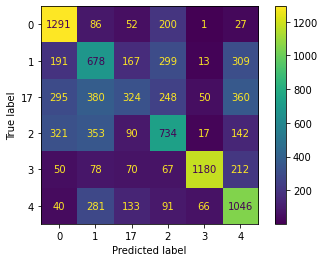

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2885 Acc: 0.4271
val Epoch Entropy: 2.0532
val Balanced Accuracy: 1.0000



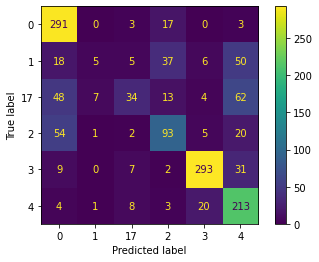

<Figure size 576x432 with 0 Axes>

Epoch 57/59
----------

train Loss: 1.2151 Acc: 0.5289
train Epoch Entropy: 1.7535
train Balanced Accuracy: 0.8000



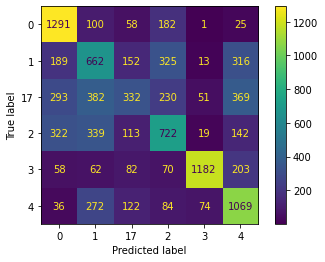

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2828 Acc: 0.4242
val Epoch Entropy: 2.0536
val Balanced Accuracy: 0.5000



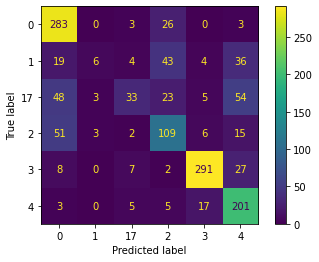

<Figure size 576x432 with 0 Axes>

Epoch 58/59
----------

train Loss: 1.2138 Acc: 0.5270
train Epoch Entropy: 1.7508
train Balanced Accuracy: 0.6667



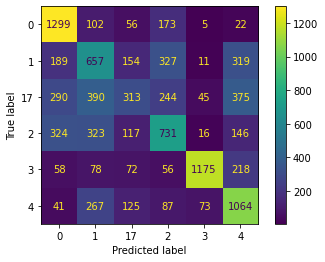

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.2795 Acc: 0.4207
val Epoch Entropy: 2.0671
val Balanced Accuracy: 0.5000



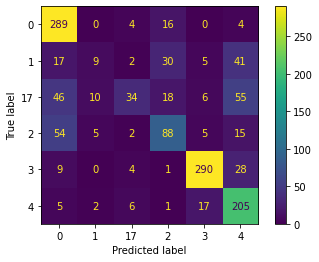

<Figure size 576x432 with 0 Axes>

Epoch 59/59
----------

train Loss: 1.2207 Acc: 0.5235
train Epoch Entropy: 1.7536
train Balanced Accuracy: 0.1667



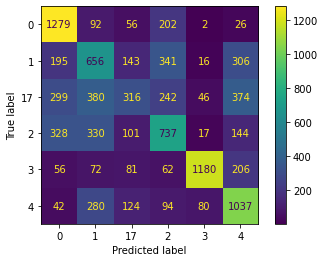

<Figure size 576x432 with 0 Axes>

Number of skipped: 310

val Loss: 0.2999 Acc: 0.4361
val Epoch Entropy: 2.0452
val Balanced Accuracy: 0.5000



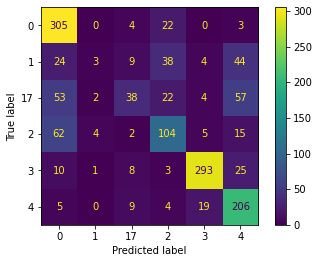

<Figure size 576x432 with 0 Axes>

Training complete in 199m 37s
Best val Acc: 0.439080
Best Val Acc. was achieved at epoch 44


In [16]:
model_list = []

for model_name in ["vgg"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)


    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val,E_accuracy_train,E_accuracy_val = train_model(trainset,valset,model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    
    model_list.append(model)



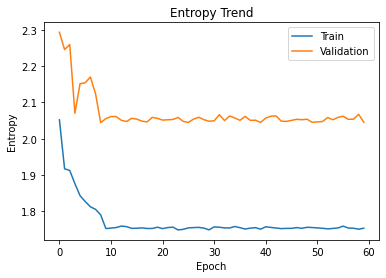

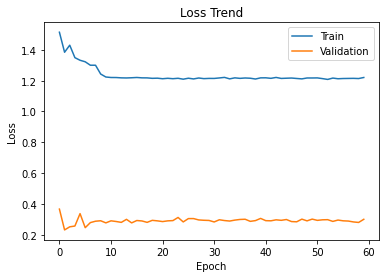

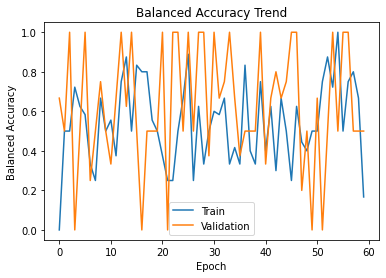

In [17]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Trend')
plt.legend()
plt.show()




In [43]:

# Assuming you have a trained model named "model"


# Define the file path to save the model
model_file1 = './model_state.pt'

# Save the model
torch.save(model.state_dict(), model_file1)

model_file2 = './model_entire.pt'

# Save the entire model
torch.save(model, model_file2)


In [40]:

# Create an instance of the ResNet50 model
model = torch.load('./model_entire.pt')

# Load the state dictionary from the model_state file
state_dict = torch.load('./model_state.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)



<All keys matched successfully>

The Test Accuracy: tensor(0.6232, device='cuda:0')
The Test Balanced Accuracy: 0.5451892606732042
Skipped Inputs: 275


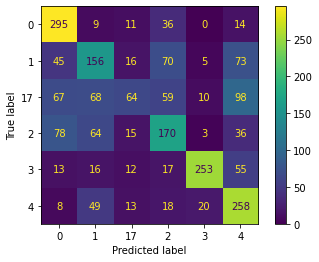

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6201, device='cuda:0')
The Test Balanced Accuracy: 0.5424682486214037
Skipped Inputs: 275


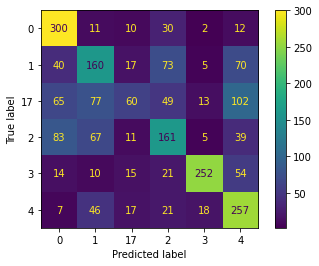

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6196, device='cuda:0')
The Test Balanced Accuracy: 0.5419954088379869
Skipped Inputs: 275


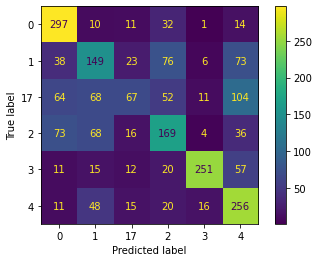

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6206, device='cuda:0')
The Test Balanced Accuracy: 0.5429161364373581
Skipped Inputs: 275


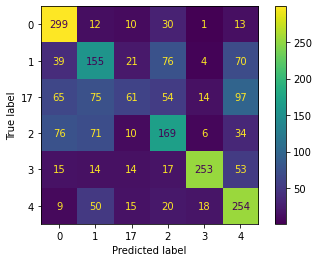

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6201, device='cuda:0')
The Test Balanced Accuracy: 0.5424570202360456
Skipped Inputs: 275


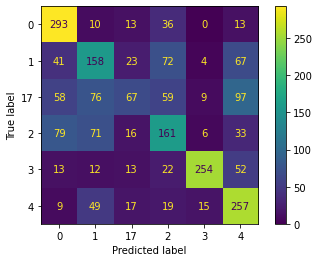

<Figure size 576x432 with 0 Axes>

In [18]:
for model in model_list:
    for hardness_threshold in [30,35,40,60,75]:
        test_model(model, testset, hardness_threshold)


In [19]:
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

In [20]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.16545123062898814


Accuracy for SVM: 0.536918869644485
Balanced Accuracy:0.5369975297552212


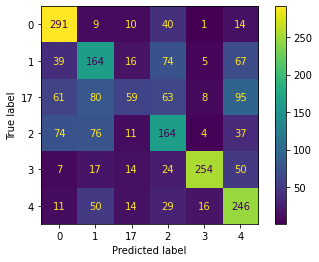

<Figure size 576x432 with 0 Axes>

In [23]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

/home/rishav/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy for MLP: 0.5214220601640839
Balanced Accuracy:0.5214661776081044


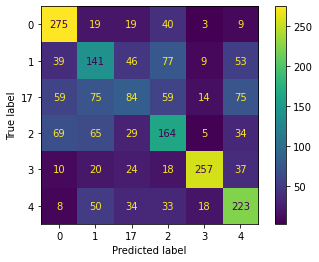

<Figure size 576x432 with 0 Axes>

In [22]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()